ref : https://qiita.com/omiita/items/429136c2f4e228d745ed

In [0]:
import os
import time
from typing import List, Dict
import re
from datetime import datetime as dt
from datetime import timedelta
import pandas as pd
import numpy as np
import boto3
from boto3.dynamodb.conditions import Key
from fastprogress import progress_bar as pb
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from umap import UMAP
from sklearn.manifold import TSNE

In [0]:
!pip install torch-geometric
!pip install torch-scatter
!pip install torch-sparse
!pip install torch-cluster

In [0]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [0]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        intermediate = x
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1), intermediate

In [0]:
dataset[0]

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [0]:
dataset[0].x[0, :]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

loss_histroy = []

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out, intermediate = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    loss_histroy.append(loss.item())

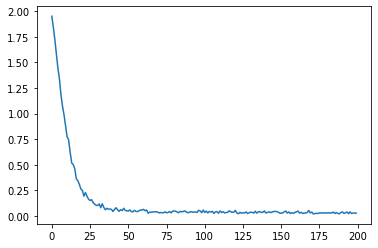

In [0]:
plt.plot(loss_histroy)

In [0]:
model.eval()
out, intermediate = model(data)
_, pred = out.max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Acc: {:.4f}' .format(acc))

Acc: 0.8030


In [0]:
out, intermediate = model(data)

In [0]:
df_labels = pd.DataFrame({
    'label': dataset[0].y.numpy()
})

In [0]:
intermediate = intermediate.cpu().detach().numpy()

In [0]:
intermediate.shape

(2708, 16)

In [0]:
intermediate_reduced = UMAP(n_components=2).fit_transform(intermediate)

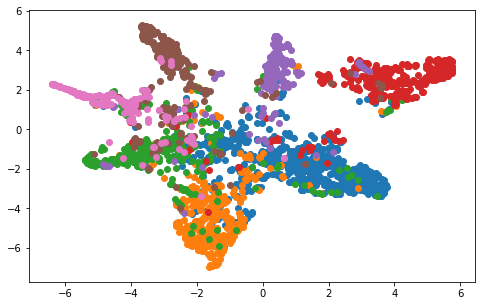

In [0]:
plt.figure(figsize=(8, 5))
for label in df_labels['label'].unique():
    indices = list(df_labels[df_labels['label'] == label].index)
    plt.scatter(intermediate_reduced[indices, 0], intermediate_reduced[indices, 1])